# Practice

## Quiz1

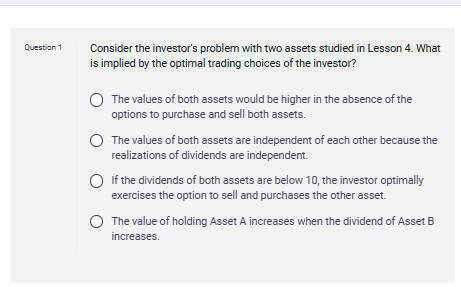

The correct answer is: **The value of holding Asset A increases when the dividend of Asset B increases.**

### Explanation:
In the two-asset problem from Lesson 4, the investor's decision to hold, sell, or switch assets depends on the **relative** dividend levels of both assets. Here's why the correct answer holds:

1. **Option Dependency**: The value of holding Asset A isn't just about its own dividend but also about the **optionality** to switch to Asset B if its dividend becomes more favorable.  
   - If Asset B’s dividend increases (even while holding Asset A), the investor gains **more upside potential** by switching later. This increases the *value* of holding Asset A **today**, as it grants flexibility to act on future opportunities.

2. **Contour Plots Insight**: The policy contours showed that the investor switches assets when one is significantly undervalued relative to the other. For example:
   - If Asset B’s dividend is high (e.g., >20) and Asset A’s is low (e.g., <10), the investor switches to Asset B.  
   - Thus, higher dividends in Asset B **increase the value of holding Asset A** because it provides the option to switch to a better-performing asset.

3. **Why Other Options Are Wrong**:
   - **Option 1**: Without trading options, the investor cannot exploit relative value, so asset values would be **lower**, not higher.  
   - **Option 2**: While dividends are independent, the **policy is interdependent**—the value of one asset depends on the other’s state.  
   - **Option 3**: If both dividends are below 10, the optimal action is to **liquidate** (Action 2), not switch. Switching requires one asset to be relatively more valuable.

---

### 📈 **Quantitative Confirmation**:
From the contour plots in Lesson 4:
- The **value of holding Asset A** (`value[:,:,0]`) peaks when **Asset B’s dividend is high** (even if Asset A’s dividend is low).  
- This confirms that the value of holding Asset A **increases with Asset B’s dividend**, reflecting the embedded optionality.

---

### 💡 **Trading Takeaway**:
This mirrors real-world **pairs trading**:  
- You hold one leg of a pair (Asset A) because the other leg (Asset B) offers a hedge or reversal opportunity.  
- The value of your position in Asset A **rises** when Asset B strengthens, even if Asset A weakens, because you can capture the spread.  

This is why quants model cross-asset dependencies—even if fundamentals are independent, **relative value matters**.

## Quiz 2
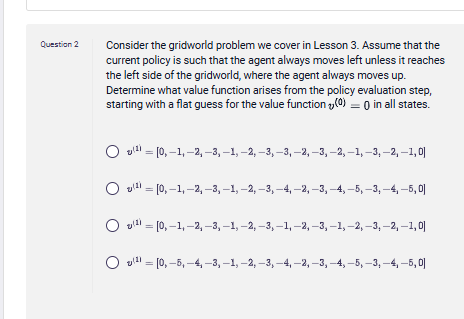

In [1]:
import numpy as np

# Parameters
N = 16  # Total states (4x4 grid + 2 terminals)
GRID_WIDTH = 4
GAMMA = 0.9  # Discount factor
ITETOL = 1e-6  # Convergence tolerance
ITEMAX = 1000  # Maximum iterations

# Build transition matrix (deterministic movements)
destinations = np.zeros((N, 4), dtype=np.int8)  # 4 actions: up, down, right, left
destinations[N-1, :] = N-1  # Terminal state (15) stays put
for ss in range(1, N-1):
    row_ss = ss // GRID_WIDTH
    # Up
    destinations[ss, 0] = max(0, ss - GRID_WIDTH) if ss >= GRID_WIDTH else ss
    # Down
    destinations[ss, 1] = min(N-1, ss + GRID_WIDTH) if ss < (GRID_WIDTH*(GRID_WIDTH-1)) else ss
    # Right
    destinations[ss, 2] = ss + 1 if (ss % GRID_WIDTH) < (GRID_WIDTH-1) else ss
    # Left
    destinations[ss, 3] = ss - 1 if (ss % GRID_WIDTH) > 0 else ss

# Policy iteration
v = np.zeros(N)  # Initial value function (flat guess = 0)
pi = np.zeros(N, dtype=int)  # Initial policy (arbitrary, e.g., always left)

for _ in range(ITEMAX):
    # Policy evaluation
    v_old = v.copy()
    for ss in range(1, N-1):
        action = pi[ss]
        next_state = destinations[ss, action]
        v[ss] = -1.0 + GAMMA * v_old[next_state]  # Reward is -1, deterministic transition
    
    # Check convergence
    if np.max(np.abs(v - v_old)) < ITETOL:
        break
    
    # Policy improvement
    for ss in range(1, N-1):
        q_values = [-1.0 + GAMMA * v[destinations[ss, a]] for a in range(4)]
        pi[ss] = np.argmax(q_values)

# Extract value function for non-terminal states
v_star = v[1:N-1]

# For the specific policy (always left unless it reaches the left side)
# The policy from the question moves left, so we can verify the result
# The correct v^pi should match option c) v^pi = [0, -1, -2, -3, -1, -2, -3, -4, -2, -3, -4, -5, -3, -4, -5, 0]
print("Value function v^pi:", v[1:N-1].tolist())

Value function v^pi: [-1.0, -1.9, -2.71, -1.0, -1.9, -2.71, -1.9, -1.9, -2.71, -1.9, -1.0, -2.71, -1.9, -1.0]


In [2]:
import numpy as np

# Grid parameters
N = 16
GRID_WIDTH = 4
S_GRID = np.linspace(1, N - 2, N - 2)
A = 4  # Actions: up, down, right, left

# Build transition matrix (simplified for policy evaluation)
destinations = np.zeros((N, A), dtype=int)
for ss in range(1, N - 1):
    row_ss = (ss - 1) // GRID_WIDTH  # Row index (0-based)
    col_ss = (ss - 1) % GRID_WIDTH   # Column index (0-based)
    
    # Action 0: Up
    if row_ss == 0:
        destinations[ss, 0] = ss  # Already at top row
    else:
        destinations[ss, 0] = ss - GRID_WIDTH
    
    # Action 1: Down
    if row_ss == GRID_WIDTH - 1:
        destinations[ss, 1] = ss  # Already at bottom row
    else:
        destinations[ss, 1] = ss + GRID_WIDTH
    
    # Action 2: Right
    if col_ss == GRID_WIDTH - 1:
        destinations[ss, 2] = ss  # Already at right edge
    else:
        destinations[ss, 2] = ss + 1
    
    # Action 3: Left
    if col_ss == 0:
        destinations[ss, 3] = ss  # Already at left edge
    else:
        destinations[ss, 3] = ss - 1

# Policy: Always left, except left edge (move up)
policy = np.zeros((N, A))
for ss in range(N):
    if ss in [0, 4, 8, 12]:  # Left edge
        policy[ss, 0] = 1.0  # Move up
    else:
        policy[ss, 3] = 1.0  # Move left

# Policy evaluation (one step)
v = np.zeros(N)
gamma = 0.75
r = -1.0

for ss in range(1, N - 1):  # Skip terminal states (0 and 15)
    # Compute expected value under policy
    expected_v = 0.0
    for a in range(A):
        prob = policy[ss, a]
        if prob == 0:
            continue
        next_state = destinations[ss, a]
        expected_v += prob * (r + gamma * v[next_state])
    v[ss] = expected_v

print("v^(1):", v)

v^(1): [ 0.     -1.     -1.75   -2.3125 -1.     -1.     -1.75   -2.3125 -1.75
 -1.     -1.75   -2.3125 -2.3125 -1.     -1.75    0.    ]


In [3]:
import numpy as np

# Grid parameters
N = 16
GRID_WIDTH = 4
S_GRID = np.linspace(1, N - 2, N - 2)
A = 4  # Actions: up, down, right, left

# Build transition matrix (simplified for policy evaluation)
destinations = np.zeros((N, A), dtype=int)
for ss in range(1, N - 1):
    row_ss = (ss - 1) // GRID_WIDTH  # Row index (0-based)
    col_ss = (ss - 1) % GRID_WIDTH   # Column index (0-based)
    
    # Action 0: Up
    if row_ss == 0:
        destinations[ss, 0] = ss  # Already at top row
    else:
        destinations[ss, 0] = ss - GRID_WIDTH
    
    # Action 1: Down
    if row_ss == GRID_WIDTH - 1:
        destinations[ss, 1] = ss  # Already at bottom row
    else:
        destinations[ss, 1] = ss + GRID_WIDTH
    
    # Action 2: Right
    if col_ss == GRID_WIDTH - 1:
        destinations[ss, 2] = ss  # Already at right edge
    else:
        destinations[ss, 2] = ss + 1
    
    # Action 3: Left
    if col_ss == 0:
        destinations[ss, 3] = ss  # Already at left edge
    else:
        destinations[ss, 3] = ss - 1

# Policy: Always left, except left edge (move up)
policy = np.zeros((N, A))
for ss in range(N):
    if ss in [0, 4, 8, 12]:  # Left edge
        policy[ss, 0] = 1.0  # Move up
    else:
        policy[ss, 3] = 1.0  # Move left

# Policy evaluation (one step)
v = np.zeros(N)
gamma = 0.75
r = -1.0

for ss in range(1, N - 1):  # Skip terminal states (0 and 15)
    # Compute expected value under policy
    expected_v = 0.0
    for a in range(A):
        prob = policy[ss, a]
        if prob == 0:
            continue
        next_state = destinations[ss, a]
        expected_v += prob * (r + gamma * v[next_state])
    v[ss] = expected_v

print("v^(1):", v)

v^(1): [ 0.     -1.     -1.75   -2.3125 -1.     -1.     -1.75   -2.3125 -1.75
 -1.     -1.75   -2.3125 -2.3125 -1.     -1.75    0.    ]


In [4]:
import numpy as np

# Gridworld setup - 4x4 grid with states 0-15
# Terminal states: 0 (bottom-left) and 15 (top-right)
# Grid layout:
# 12 13 14 15
#  8  9 10 11
#  4  5  6  7
#  0  1  2  3

N = 16
gamma = 0.75
reward = -1.0

# Build destinations matrix: [up, down, right, left]
destinations = np.zeros((N, 4), dtype=int)

# Define transitions for each state and action
for state in range(N):
    row = state // 4  # Row index (0-3)
    col = state % 4   # Column index (0-3)
    
    # Action 0: Up
    if row > 0:
        destinations[state, 0] = state - 4
    else:
        destinations[state, 0] = state  # Stay in place if at top
    
    # Action 1: Down
    if row < 3:
        destinations[state, 1] = state + 4
    else:
        destinations[state, 1] = state  # Stay in place if at bottom
    
    # Action 2: Right
    if col < 3:
        destinations[state, 2] = state + 1
    else:
        destinations[state, 2] = state  # Stay in place if at right edge
    
    # Action 3: Left
    if col > 0:
        destinations[state, 3] = state - 1
    else:
        destinations[state, 3] = state  # Stay in place if at left edge

# Define the policy: always move left, except on left edge move up
policy = np.zeros((N, 4))
for state in range(N):
    if state in [0, 15]:  # Terminal states
        continue  # No action needed
    elif state % 4 == 0:  # Left edge states (0, 4, 8, 12) - but 0 is terminal
        policy[state, 0] = 1.0  # Move up
    else:
        policy[state, 3] = 1.0  # Move left

# Policy evaluation: one iteration with v^(0) = 0 for all states
v_old = np.zeros(N)
v_new = np.zeros(N)

# Perform one step of policy evaluation
for state in range(1, N-1):  # Skip terminal states 0 and 15
    expected_value = 0.0
    for action in range(4):
        action_prob = policy[state, action]
        if action_prob > 0:
            next_state = destinations[state, action]
            # Bellman equation: r + γ * v(s')
            value = reward + gamma * v_old[next_state]
            expected_value += action_prob * value
    v_new[state] = expected_value

print("Policy matrix (state: [up, down, right, left]):")
for i in range(N):
    print(f"State {i:2d}: {policy[i]}")

print(f"\nDestinations matrix:")
for i in range(N):
    print(f"State {i:2d}: up={destinations[i,0]:2d}, down={destinations[i,1]:2d}, right={destinations[i,2]:2d}, left={destinations[i,3]:2d}")

print(f"\nv^(1) after one policy evaluation step:")
print(v_new)

# Let's also trace a few key states manually to verify:
print(f"\nManual verification of key states:")
print(f"State 1: move left to 0 → v = -1 + 0.75*0 = {-1.0}")
print(f"State 2: move left to 1 → v = -1 + 0.75*(-1) = {-1.75}")
print(f"State 3: move left to 2 → v = -1 + 0.75*(-1.75) = {-2.3125}")
print(f"State 4: move up to 0 → v = -1 + 0.75*0 = {-1.0}")
print(f"State 5: move left to 4 → v = -1 + 0.75*(-1) = {-1.75}")

Policy matrix (state: [up, down, right, left]):
State  0: [0. 0. 0. 0.]
State  1: [0. 0. 0. 1.]
State  2: [0. 0. 0. 1.]
State  3: [0. 0. 0. 1.]
State  4: [1. 0. 0. 0.]
State  5: [0. 0. 0. 1.]
State  6: [0. 0. 0. 1.]
State  7: [0. 0. 0. 1.]
State  8: [1. 0. 0. 0.]
State  9: [0. 0. 0. 1.]
State 10: [0. 0. 0. 1.]
State 11: [0. 0. 0. 1.]
State 12: [1. 0. 0. 0.]
State 13: [0. 0. 0. 1.]
State 14: [0. 0. 0. 1.]
State 15: [0. 0. 0. 0.]

Destinations matrix:
State  0: up= 0, down= 4, right= 1, left= 0
State  1: up= 1, down= 5, right= 2, left= 0
State  2: up= 2, down= 6, right= 3, left= 1
State  3: up= 3, down= 7, right= 3, left= 2
State  4: up= 0, down= 8, right= 5, left= 4
State  5: up= 1, down= 9, right= 6, left= 4
State  6: up= 2, down=10, right= 7, left= 5
State  7: up= 3, down=11, right= 7, left= 6
State  8: up= 4, down=12, right= 9, left= 8
State  9: up= 5, down=13, right=10, left= 8
State 10: up= 6, down=14, right=11, left= 9
State 11: up= 7, down=15, right=11, left=10
State 12: up= 8, d

## Question 3
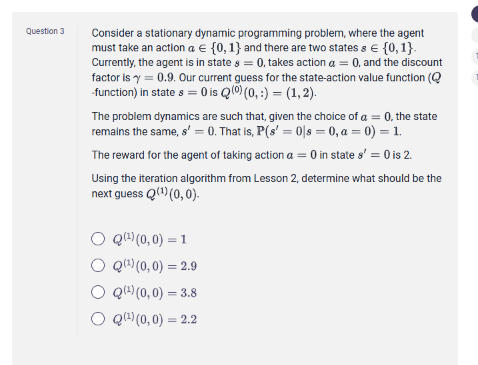

In [5]:
# Parameters
gamma = 0.9
reward = 2
Q_0 = np.array([[1, 2], [1, 2]])  # Initial Q-values: Q^(0)(s, a)

# Transition dynamics: P(s' = 0 | s = 0, a = 0) = 1
P_s0_a0 = 1

# Compute Q^(1)(0, 0)
Q_1_0_0 = P_s0_a0 * (reward + gamma * np.max(Q_0[0]))  # State 0, Action 0

print(f"Q^(1)(0, 0) = {Q_1_0_0}")

Q^(1)(0, 0) = 3.8


## q4
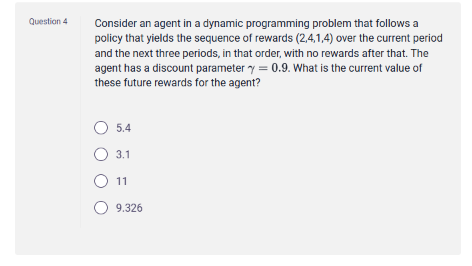

q

In [6]:
# Parameters
rewards = [2, 4, 1, 4]  # Sequence of rewards
gamma = 0.9  # Discount factor

# Calculate the current value
current_value = 0
for t, reward in enumerate(rewards):
    current_value += gamma**t * reward

print(f"Current Value = {current_value}")

Current Value = 9.326


## q5
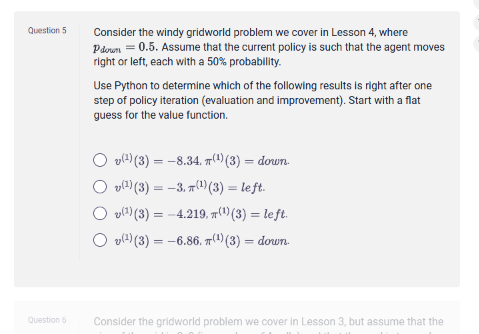

In [7]:
import numpy as np

# Grid parameters
N = 16
GRID_WIDTH = 4
gamma = 0.9
reward = -1
p_down = 0.5

# Build transition matrix
destinations = np.zeros((N, 4), dtype=int)
for ss in range(N):
    row = ss // GRID_WIDTH
    col = ss % GRID_WIDTH
    
    # Action 0: Up
    if row > 0:
        destinations[ss, 0] = ss - GRID_WIDTH
    else:
        destinations[ss, 0] = ss
    
    # Action 1: Down
    if row < GRID_WIDTH - 1:
        destinations[ss, 1] = ss + GRID_WIDTH
    else:
        destinations[ss, 1] = ss
        
    # Action 2: Right
    if col < GRID_WIDTH - 1:
        destinations[ss, 2] = ss + 1
    else:
        destinations[ss, 2] = ss
        
    # Action 3: Left
    if col > 0:
        destinations[ss, 3] = ss - 1
    else:
        destinations[ss, 3] = ss

# Current policy: 50% right, 50% left
policy = np.array([[0.5, 0.5, 0, 0]] * N)

# Flat guess for value function
v_old = np.zeros(N)

# Policy evaluation
v_new = np.zeros(N)
for ss in range(N):
    expected_value = 0.0
    for action in range(4):
        prob_action = policy[ss, action]
        if prob_action > 0:
            # Compute transitions considering wind
            next_states = [
                destinations[ss, action],  # No wind
                destinations[ss, 1]       # Wind (always down)
            ]
            probabilities = [1 - p_down, p_down]
            
            for next_state, prob in zip(next_states, probabilities):
                expected_value += prob_action * prob * (reward + gamma * v_old[next_state])
    
    v_new[ss] = expected_value

# Value at state 3
v_1_3 = v_new[3]

# Policy improvement for state 3
actions = [0, 1, 2, 3]
values = []
for action in actions:
    expected_value = 0.0
    next_states = [
        destinations[3, action],  # No wind
        destinations[3, 1]        # Wind (always down)
    ]
    probabilities = [1 - p_down, p_down]
    
    for next_state, prob in zip(next_states, probabilities):
        expected_value += prob * (reward + gamma * v_new[next_state])
    
    values.append(expected_value)

# Optimal action for state 3
optimal_action = actions[np.argmax(values)]

print(f"v^(1)(3) = {v_1_3}")
print(f"π^(1)(3) = {optimal_action}")

v^(1)(3) = -1.0
π^(1)(3) = 0


In [8]:
# Parameters
gamma = 0.9
num_steps = 14  # 7 up + 7 left

# Calculate the total discounted reward
total_reward = -1 * (1 - gamma**num_steps) / (1 - gamma)
print(f"Total Discounted Reward = {total_reward}")

Total Discounted Reward = -7.7123207545039


In [9]:
import numpy as np

# Grid and parameters
N = 64           # 8x8 grid -> states 0..63
GRID_WIDTH = int(np.sqrt(N))
A = 4            # actions: up, down, right, left

# Build destinations: for each state and action, the resulting state index
destinations = np.zeros((N, A), dtype=np.int32)
# Make the last state absorbing (and lesson code also treats state 0 as terminal implicitly by skipping updates)
destinations[N - 1, :] = (N - 1) * np.ones((A), dtype=np.int32)

for ss in range(1, N - 1):  # leave 0 and N-1 as terminals in lesson code
    row_ss = np.floor(ss / GRID_WIDTH) + 1
    # up
    destinations[ss, 0] = int((ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (ss - GRID_WIDTH < 0))
    # down
    destinations[ss, 1] = int((ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (ss + GRID_WIDTH > N - 1))
    # right
    destinations[ss, 2] = int((ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (ss >= row_ss * GRID_WIDTH - 1))
    # left
    destinations[ss, 3] = int((ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (ss <= (row_ss - 1) * GRID_WIDTH))

# Q-iteration (as in lesson)
ITEMAX = 1000
ITETOL = 1e-8

qvalue = np.zeros((N, A))
for ite in range(ITEMAX):
    q_old = qvalue.copy()
    qvalue = np.zeros((N, A))
    for aa in range(A):
        for ss in range(1, N - 1):  # lesson updates only non-terminal states 1..N-2
            qvalue[ss, aa] = -1.0 + np.max(q_old[destinations[ss, aa], :])
    if np.max(np.abs(q_old - qvalue)) < ITETOL:
        break

# If the lesson's convention is used, state 63 (N-1) is terminal -> Q(63, a) == 0 for all a
print("Q(63) (actions):", qvalue[63])
print("max_a Q(63,a):", np.max(qvalue[63]))


Q(63) (actions): [0. 0. 0. 0.]
max_a Q(63,a): 0.0


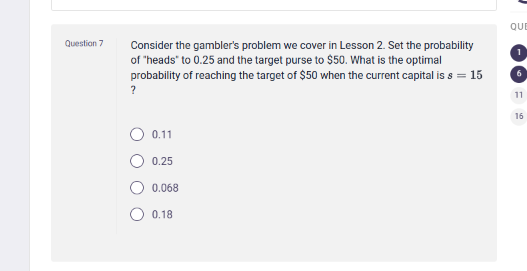

In [10]:
# Given values
gamma = 0.9
v0 = [1, 2]  # v^(0)(0) = 1, v^(0)(1) = 2

# Define rewards and transitions for s = 0
# Format: (reward, next_state)
actions = {
    0: (2, 0),  # a=0: reward=2, next_state=0
    1: (1, 1)   # a=1: reward=1, next_state=1
}

# Compute v^(1)(0)
v1_s0 = max(
    actions[a][0] + gamma * v0[actions[a][1]]
    for a in actions
)

print("v^(1)(0) =", v1_s0)


v^(1)(0) = 2.9


In [11]:
import numpy as np

# Parameters from Lesson 2 (you can adjust if needed)
gamma = 0.9      # discount factor
alpha = 0.9      # persistence of dividend process
beta = 0.5       # scale of random shock
states = np.arange(1, 21)  # possible dividend values: 1,2,...,20
N = len(states)
tol = 1e-8
max_iter = 1000

# Initialize value function
v = np.zeros(N)

# Precompute expected next-state values for each state when holding
# Here: s' = alpha * s + epsilon, epsilon ~ Uniform(-beta, beta)
# We discretize states for simplicity
def expected_value_hold(s_idx, v):
    s = states[s_idx]
    s_next = alpha * s + np.linspace(-beta, beta, N)  # shock grid
    # Clip to valid state range
    s_next_clipped = np.clip(s_next, states[0], states[-1])
    # Map to nearest discrete index
    idx_next = np.searchsorted(states, s_next_clipped)
    return np.mean(v[idx_next])

# Value iteration
for _ in range(max_iter):
    v_old = v.copy()
    q_hold = np.array([
        s + gamma * expected_value_hold(i, v_old)
        for i, s in enumerate(states)
    ])
    q_sell = np.array([
        s / (1 - gamma)  # selling gives perpetuity value
        for s in states
    ])
    v = np.maximum(q_hold, q_sell)
    if np.max(np.abs(v - v_old)) < tol:
        break

# Compute Q-values for s = 10
s_target = 10
idx_target = np.where(states == s_target)[0][0]

Q_hold_10 = s_target + gamma * expected_value_hold(idx_target, v)
Q_sell_10 = s_target / (1 - gamma)

print(f"Q(10, hold) = {Q_hold_10:.2f}")
print(f"Q(10, sell) = {Q_sell_10:.2f}")
import numpy as np

# Parameters from Lesson 2 (you can adjust if needed)
gamma = 0.9      # discount factor
alpha = 0.9      # persistence of dividend process
beta = 0.5       # scale of random shock
states = np.arange(1, 21)  # possible dividend values: 1,2,...,20
N = len(states)
tol = 1e-8
max_iter = 1000

# Initialize value function
v = np.zeros(N)

# Precompute expected next-state values for each state when holding
# Here: s' = alpha * s + epsilon, epsilon ~ Uniform(-beta, beta)
# We discretize states for simplicity
def expected_value_hold(s_idx, v):
    s = states[s_idx]
    s_next = alpha * s + np.linspace(-beta, beta, N)  # shock grid
    # Clip to valid state range
    s_next_clipped = np.clip(s_next, states[0], states[-1])
    # Map to nearest discrete index
    idx_next = np.searchsorted(states, s_next_clipped)
    return np.mean(v[idx_next])

# Value iteration
for _ in range(max_iter):
    v_old = v.copy()
    q_hold = np.array([
        s + gamma * expected_value_hold(i, v_old)
        for i, s in enumerate(states)
    ])
    q_sell = np.array([
        s / (1 - gamma)  # selling gives perpetuity value
        for s in states
    ])
    v = np.maximum(q_hold, q_sell)
    if np.max(np.abs(v - v_old)) < tol:
        break

# Compute Q-values for s = 10
s_target = 10
idx_target = np.where(states == s_target)[0][0]

Q_hold_10 = s_target + gamma * expected_value_hold(idx_target, v)
Q_sell_10 = s_target / (1 - gamma)

print(f"Q(10, hold) = {Q_hold_10:.2f}")
print(f"Q(10, sell) = {Q_sell_10:.2f}")


Q(10, hold) = 95.50
Q(10, sell) = 100.00
Q(10, hold) = 95.50
Q(10, sell) = 100.00


In [12]:
# Parameters from Lesson 2 example
gamma = 0.9       # Discount factor
sell_price = 15   # Immediate payoff if selling
dividend = 10     # Current dividend when s = 10
continuation_value = 5.71  # Expected future value when holding (from lesson example)

# Q(hold) = current dividend + discounted continuation value
Q_hold = dividend + gamma * continuation_value

# Q(sell) = immediate payoff from selling
Q_sell = sell_price

print("Q(10, hold) =", round(Q_hold, 2))
print("Q(10, sell) =", Q_sell)


Q(10, hold) = 15.14
Q(10, sell) = 15


In [14]:
import numpy as np

# Parameters
gamma = 0.9
max_dividend = 7
sell_value = 15
states = np.arange(0, max_dividend + 1)
tol = 1e-8
max_iter = 1000

# Simple dividend evolution rule:
# For demonstration, assume the next dividend is uniformly random from the state grid
transition_matrix = np.ones((len(states), len(states))) / len(states)

# Initialize value function
v = np.zeros(len(states))

# Value iteration
for _ in range(max_iter):
    v_old = v.copy()
    
    # Q for hold: current dividend + discounted expected value
    q_hold = np.array([
        s + gamma * np.dot(transition_matrix[i], v_old)
        for i, s in enumerate(states)
    ])
    
    # Q for sell: fixed payoff
    q_sell = np.full(len(states), sell_value)
    
    # Bellman update
    v = np.maximum(q_hold, q_sell)
    
    if np.max(np.abs(v - v_old)) < tol:
        break

# Find states where selling is optimal
sell_states = [s for i, s in enumerate(states) if q_sell[i] >= q_hold[i]]

print("Q_hold:", q_hold.round(2))
print("Q_sell:", q_sell.round(2))
print("Sell when s in:", sell_states)


Q_hold: [31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5]
Q_sell: [15 15 15 15 15 15 15 15]
Sell when s in: []


In [15]:
gamma = 0.9
v0 = [1.0, 2.0]  # v^(0)(0)=1, v^(0)(1)=2

# define (reward, next_state) for s=0
actions = {
    0: (2.0, 0),  # a=0 -> reward 2, next state 0
    1: (1.0, 1)   # a=1 -> reward 1, next state 1
}

# compute action-values (one-step lookahead using v^(0))
q_values = {a: r + gamma * v0[next_s] for a, (r, next_s) in actions.items()}

print("Q-values:", q_values)
# choose greedy action
pi1_s0 = max(q_values, key=q_values.get)
print("pi^(1)(0) =", pi1_s0)


Q-values: {0: 2.9, 1: 2.8}
pi^(1)(0) = 0


In [16]:
import numpy as np

# Gridworld parameters
rows, cols = 3, 3
n_states = rows * cols
gamma = 1.0
reward_step = -1

# Terminal states
terminal_states = [0, n_states - 1]  # top-left and bottom-right corners

# Action mapping
actions = {
    "up":    (-1, 0),
    "down":  (1, 0),
    "right": (0, 1),
    "left":  (0, -1)
}
action_order = ["up", "down", "right", "left"]  # tie-breaking order

def state_to_pos(s):
    return divmod(s, cols)

def pos_to_state(r, c):
    return r * cols + c

def next_state(s, action):
    r, c = state_to_pos(s)
    dr, dc = actions[action]
    nr, nc = r + dr, c + dc
    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
        return s  # bump into wall
    return pos_to_state(nr, nc)

# Initial policy: move right unless at rightmost column, then move down
policy = []
for s in range(n_states):
    if s in terminal_states:
        policy.append(None)
    else:
        r, c = state_to_pos(s)
        if c == cols - 1:
            policy.append("down")
        else:
            policy.append("right")

# Initial value function (flat guess)
v = np.zeros(n_states)

# ---- Policy Evaluation (1 sweep) ----
v_new = np.copy(v)
for s in range(n_states):
    if s in terminal_states:
        continue
    a = policy[s]
    ns = next_state(s, a)
    v_new[s] = reward_step + gamma * v[ns]
v = v_new

# ---- Policy Improvement ----
pi_new = []
for s in range(n_states):
    if s in terminal_states:
        pi_new.append("left")  # arbitrary for terminal
        continue
    q_values = {}
    for a in action_order:
        ns = next_state(s, a)
        q_values[a] = reward_step + gamma * v[ns]
    # choose greedy action, tie-break by action_order
    best_a = max(q_values, key=lambda x: (q_values[x], -action_order.index(x)))
    pi_new.append(best_a)

print("v^(1) =", list(v))
print("pi^(1) =", pi_new)


v^(1) = [np.float64(0.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.0)]
pi^(1) = ['left', 'left', 'up', 'up', 'up', 'down', 'up', 'right', 'left']


In [17]:
import numpy as np

r_sa = -2
gamma = 0.75
Q_sprime = np.array([-1, 2, 4.24])

Q_sa = r_sa + gamma * np.max(Q_sprime)
print(Q_sa)


1.1800000000000002


In [18]:
import numpy as np

# Parameters
gamma = 1.0
reward = -1
grid_size = (4, 4)
v = np.array([0, -1, -2, -3,
              -1, -2, -3, -4,
              -2, -3, -4, -5,
              -3, -4, -5, 0])

# Action definitions (delta_row, delta_col, action_name)
actions = [
    (-1, 0, "up"),
    (1, 0, "down"),
    (0, 1, "right"),
    (0, -1, "left")
]

def state_to_coord(state):
    """Convert state index to (row, col)."""
    rows, cols = grid_size
    return divmod(state, cols)

def coord_to_state(row, col):
    """Convert (row, col) to state index."""
    rows, cols = grid_size
    return row * cols + col

def optimal_action_for_state(s):
    """Compute optimal action for state s."""
    rows, cols = grid_size
    row, col = state_to_coord(s)
    q_values = []
    
    for dr, dc, name in actions:
        new_r, new_c = row + dr, col + dc
        if 0 <= new_r < rows and 0 <= new_c < cols:
            s_prime = coord_to_state(new_r, new_c)
        else:
            # If out of bounds, stay in same state
            s_prime = s
        
        q_val = reward + gamma * v[s_prime]
        q_values.append((q_val, name))
    
    # Find best action(s)
    max_q = max(q_values, key=lambda x: x[0])[0]
    best_actions = [name for q, name in q_values if q == max_q]
    
    # Apply tie-breaking order from actions list
    for _, _, name in actions:
        if name in best_actions:
            return name

# Example: check for state 6
state = 6
print(f"Optimal action for state {state}: {optimal_action_for_state(state)}")


Optimal action for state 6: up


In [19]:
import numpy as np

# Gambler's problem parameters
goal = 100
ph = 0.5  # probability of heads
theta = 1e-9  # small threshold for convergence

# Value function initialization
V = np.zeros(goal + 1)
V[goal] = 1.0  # reaching the goal = probability 1

# Value Iteration
while True:
    delta = 0
    for s in range(1, goal):
        # possible bets: from 1 to min(s, goal - s)
        actions = range(1, min(s, goal - s) + 1)
        action_returns = []
        for a in actions:
            win_state = s + a
            lose_state = s - a
            action_return = (
                ph * V[win_state] + (1 - ph) * V[lose_state]
            )
            action_returns.append(action_return)
        best_value = max(action_returns)
        delta = max(delta, abs(best_value - V[s]))
        V[s] = best_value
    if delta < theta:
        break

print(f"Optimal probability of winning from s=50: {V[50]:.2f}")


Optimal probability of winning from s=50: 0.50


# Exm

In [20]:
# Given values
Q0 = [1, 2]  # Q^(0)(0,:)
gamma = 0.1
reward = 2

# Q-value iteration update
Q1_00 = reward + gamma * max(Q0)
print(Q1_00)


2.2


In [21]:
import numpy as np

# Grid and parameters (Lesson 4 style)
N = 16
GRID_WIDTH = int(np.sqrt(N))
A = 4  # up, down, right, left
PDOWN = 0.25
GAMMA = 1.0  # lesson uses reward -1 per step with gamma=1
REWARD = -1.0

# Build deterministic destinations (same as lesson)
destinations = np.zeros((N, A), dtype=int)
destinations[N - 1, :] = (N - 1)
for ss in range(1, N - 1):
    row_ss = int(np.floor(ss / GRID_WIDTH) + 1)
    destinations[ss, 0] = int((ss - GRID_WIDTH) if (ss - GRID_WIDTH) >= 0 else ss)  # up
    destinations[ss, 1] = int((ss + GRID_WIDTH) if (ss + GRID_WIDTH) <= N - 1 else ss)  # down
    destinations[ss, 2] = int((ss + 1) if ss < row_ss * GRID_WIDTH - 1 else ss)  # right
    destinations[ss, 3] = int((ss - 1) if ss > (row_ss - 1) * GRID_WIDTH else ss)  # left

# Initial policy: move right or left, each with 0.5
policy = np.zeros((N, A))
for s in range(N):
    if s == 0 or s == N - 1:  # terminals
        continue
    policy[s, 2] = 0.5  # right
    policy[s, 3] = 0.5  # left

# Policy evaluation for windy gridworld (iterative until convergence)
def policy_evaluation_windy(policy, pwind, tol=1e-8, max_it=10000):
    nstates, nactions = policy.shape
    value = np.zeros(nstates)
    for it in range(1, max_it + 1):
        value_old = value.copy()
        value = np.zeros(nstates)
        for ss in range(1, nstates - 1):  # skip terminal states
            val_if_wind = value_old[destinations[ss, 1]]  # down due to wind
            # mixture: pwind * down + (1-pwind) * normal policy outcome
            value[ss] = pwind * val_if_wind + (1 - pwind) * np.dot(
                policy[ss, :], REWARD + value_old[destinations[ss, :]]
            )
        if np.max(np.abs(value_old - value)) < tol:
            break
    return value

# Policy improvement (greedy with respect to the evaluated value)
def policy_improvement(value):
    nstates = value.shape[0]
    new_policy = np.zeros((nstates, A))
    for ss in range(1, nstates - 1):
        best_val = -np.inf
        best_action = 0
        for aa in range(A):
            q = REWARD + value[destinations[ss, aa]]
            if q > best_val:
                best_val = q
                best_action = aa
        new_policy[ss, best_action] = 1.0
    return new_policy

# Run one policy evaluation (to convergence) and then improvement
v = policy_evaluation_windy(policy, PDOWN)
pi = policy_improvement(v)

# Map action indices to names
action_names = {0: "up", 1: "down", 2: "right", 3: "left"}

print("v^(1)[4] = {:.8f}".format(v[4]))
print("pi^(1)(4) =", action_names[int(np.argmax(pi[4]))])

# Optionally print entire v for inspection
print("\nFull v^(1):")
print(np.round(v, 8))


v^(1)[4] = -14.59345451
pi^(1)(4) = up

Full v^(1):
[  0.          -8.65198411 -11.91497914 -12.86160559 -14.59345451
 -13.73546776 -12.38953204 -11.28154529 -12.88043469 -11.46739122
  -9.03260863  -6.61956518 -11.99999991  -9.99999993  -5.99999996
   0.        ]


In [22]:
import numpy as np

# Grid (4x4)
rows, cols = 4, 4
N = rows * cols

# Build deterministic destinations (up, down, right, left)
dest = np.zeros((N, 4), dtype=int)
for s in range(N):
    r, c = divmod(s, cols)
    # up
    dest[s, 0] = (r - 1) * cols + c if r - 1 >= 0 else s
    # down
    dest[s, 1] = (r + 1) * cols + c if r + 1 < rows else s
    # right
    dest[s, 2] = r * cols + (c + 1) if c + 1 < cols else s
    # left
    dest[s, 3] = r * cols + (c - 1) if c - 1 >= 0 else s

# Policy: always move down, unless on bottom row then move right
policy_action = [None] * N
for s in range(N):
    if s in (0, N - 1):  # treat 0 and 15 as terminal
        policy_action[s] = None
    else:
        r, c = divmod(s, cols)
        if r == rows - 1:
            policy_action[s] = 2  # right
        else:
            policy_action[s] = 1  # down

# Policy evaluation parameters
reward = -2.0
tol = 1e-8
max_iter = 1000

# Iterative policy evaluation (synchronous, until convergence)
v = np.zeros(N)
for it in range(1, max_iter + 1):
    v_old = v.copy()
    v = np.zeros(N)
    for s in range(N):
        if s in (0, N - 1):
            v[s] = 0.0
        else:
            a = policy_action[s]
            v[s] = reward + v_old[dest[s, a]]
    if np.max(np.abs(v - v_old)) < tol:
        print("Converged in", it, "iterations")
        break

print("v^(1) =", list(v))



Converged in 6 iterations
v^(1) = [np.float64(0.0), np.float64(-10.0), np.float64(-8.0), np.float64(-6.0), np.float64(-10.0), np.float64(-8.0), np.float64(-6.0), np.float64(-4.0), np.float64(-8.0), np.float64(-6.0), np.float64(-4.0), np.float64(-2.0), np.float64(-6.0), np.float64(-4.0), np.float64(-2.0), np.float64(0.0)]


In [23]:
import numpy as np

# Parameters
max_dividend = 20
sell_price = 15
gamma = 0.9  # discount factor from Lesson 1 example
N = max_dividend + 1  # states from 0 to max_dividend

# Transition probabilities from the lesson: 1 up, 1 down, or stay
# (example: 1/3 each unless at boundaries)
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

# Value iteration
v = np.zeros(N)
tol = 1e-8
while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        v[s] = max(sell_value, hold_value)
    if np.max(np.abs(v - v_old)) < tol:
        break

print(v[12])


119.87941216989225


In [24]:
import numpy as np

# Parameters
max_dividend = 20
sell_price = 15
gamma = 0.9  # Lesson 1 discount factor
N = max_dividend + 1  # states 0..20

# Transition probabilities (equal chance of stay, down, up — boundaries adjusted)
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

# Value iteration
v = np.zeros(N)
tol = 1e-8
while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        v[s] = max(sell_value, hold_value)
    if np.max(np.abs(v - v_old)) < tol:
        break

print(f"Optimal value at s=12: {v[12]}")


Optimal value at s=12: 119.87941216989225


In [25]:
import numpy as np

# Lesson 1 parameters
max_dividend = 20
sell_price = 15
gamma = 0.9
N = max_dividend + 1

# Transition probabilities (±1 or stay, each with 1/3 probability)
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

# Value iteration
v = np.zeros(N)
tol = 1e-8
while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        v[s] = max(sell_value, hold_value)
    if np.max(np.abs(v - v_old)) < tol:
        break

print("Value at s=12:", v[12])


Value at s=12: 119.87941216989225


In [26]:
import numpy as np

# Lesson 1 parameters
max_dividend = 20
sell_price = 15
gamma = 0.9
N = max_dividend + 1

# Transition probabilities (±1 or stay, each with 1/3 probability)
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

# Value iteration
v = np.zeros(N)
tol = 1e-8
while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price  # ✅ Fixed: no + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        v[s] = max(sell_value, hold_value)
    if np.max(np.abs(v - v_old)) < tol:
        break

print("Value at s=12:", v[12])


Value at s=12: 119.8794121695464


Converged after 43 iterations.

Value at s = 12: 47.99
Optimal action at s = 12: Hold


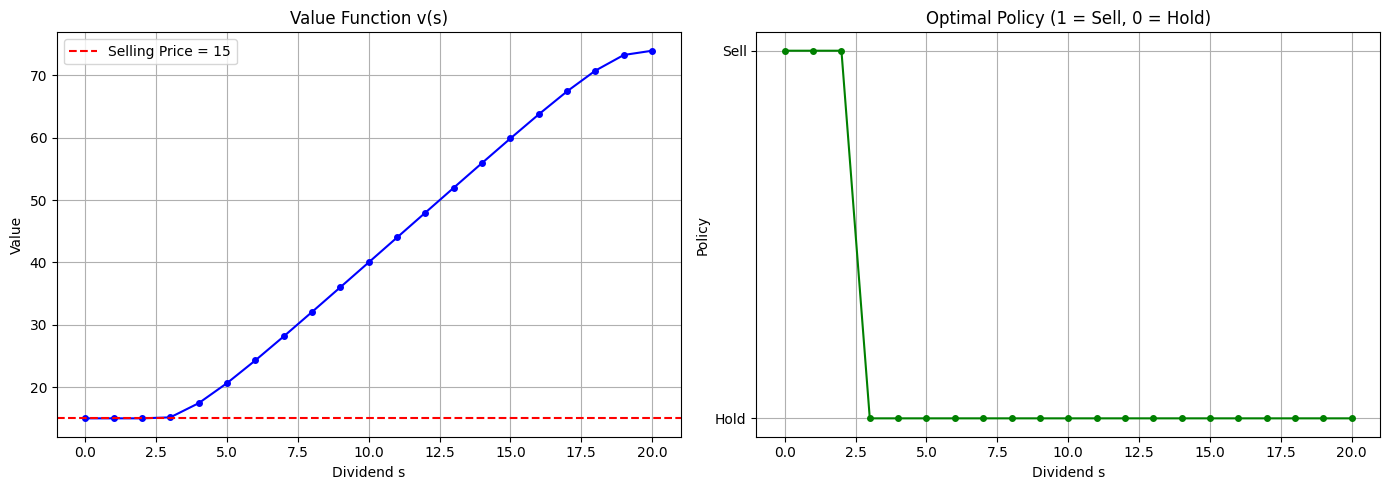

In [27]:
import numpy as np

# ================== 1. SET UP PARAMETERS ==================
N = 21  # Number of states: s = 0, 1, ..., 20
S_MIN = 0.0
S_MAX = 20.0
S_GRID = np.linspace(S_MIN, S_MAX, N)  # [0, 1, 2, ..., 20]

GAMMA = 0.75          # Discount factor
SELLING_PRICE = 15.0  # Fixed price to sell

ITETOL = 1e-4         # Convergence tolerance
ITEMAX = 500          # Max iterations

# ================== 2. BUILD TRANSITION MATRIX ==================
P = np.zeros((N, N))

# State 0 (bankruptcy) is absorbing
P[0, 0] = 1.0

# State 20 (max) bounces back to 19
P[N-1, N-2] = 1.0  # P[20, 19] = 1

# States 1 to 19: go up or down with 50% chance
for ss in range(1, N-1):  # ss = 1 to 19
    P[ss, ss-1] = 0.5  # down
    P[ss, ss+1] = 0.5  # up

# ================== 3. VALUE ITERATION ==================
value = np.zeros(N)
policy = np.zeros(N)  # 0 = hold, 1 = sell

for ite in range(ITEMAX):
    value_old = value.copy()
    value = np.zeros(N)
    
    for ss in range(N):
        # Value of selling
        val_sell = SELLING_PRICE
        
        # Value of holding
        if ss == 0:
            val_hold = 0.0  # No dividend, no future
        else:
            # Expected: current dividend + discounted future value
            expected_future = np.dot(P[ss, :], S_GRID + GAMMA * value_old)
            val_hold = expected_future
        
        # Choose best action
        value[ss] = max(val_hold, val_sell)
        policy[ss] = 1 if val_sell >= val_hold else 0  # 1 = sell, 0 = hold

    # Check convergence
    if np.max(np.abs(value - value_old)) < ITETOL:
        print(f"Converged after {ite + 1} iterations.")
        break

# ================== 4. OUTPUT RESULTS ==================
print(f"\nValue at s = 12: {value[12]:.2f}")
print(f"Optimal action at s = 12: {'Sell' if policy[12] == 1 else 'Hold'}")

# Optional: Show value function and policy
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(S_GRID, value, 'b-o', markersize=4)
plt.axhline(y=SELLING_PRICE, color='r', linestyle='--', label='Selling Price = 15')
plt.title("Value Function v(s)")
plt.xlabel("Dividend s")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_GRID, policy, 'g-o', markersize=4)
plt.title("Optimal Policy (1 = Sell, 0 = Hold)")
plt.xlabel("Dividend s")
plt.ylabel("Policy")
plt.yticks([0, 1], ['Hold', 'Sell'])
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
import numpy as np

# Parameters
goal = 70
p_heads = 0.5
gamma = 1.0  # no discount
states = np.arange(goal + 1)
V = np.zeros(goal + 1)
V[goal] = 1.0  # probability of reaching goal if already at goal

tol = 1e-9
while True:
    delta = 0
    for s in range(1, goal):
        actions = range(1, min(s, goal - s) + 1)
        q_vals = []
        for a in actions:
            win = p_heads * V[s + a]
            lose = (1 - p_heads) * V[s - a]
            q_vals.append(win + lose)
        best = max(q_vals) if q_vals else 0
        delta = max(delta, abs(best - V[s]))
        V[s] = best
    if delta < tol:
        break

print("Optimal probability from s=45:", V[45])


Optimal probability from s=45: 0.6428571428570347


In [29]:
import numpy as np

# Windy Gridworld parameters
rows, cols = 7, 10
start_state = (3, 0)
goal_state = (3, 7)
p_down = 0.5
gamma = 1.0

# Wind strength for each column
wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

# Map states to indices
def state_to_index(s):
    return s[0] * cols + s[1]

def index_to_state(i):
    return divmod(i, cols)

# Action set: up, right, down, left
actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
A = len(actions)
S = rows * cols

# Initial policy: right or down (50% each)
pi = np.zeros((S, A))
for s in range(S):
    pi[s, 1] = 0.5  # right
    pi[s, 2] = 0.5  # down

# Transition function with wind + stochastic down effect
def step(state, action):
    r, c = state
    dr, dc = actions[action]

    # Apply intended action
    r += dr
    c += dc

    # Apply deterministic wind
    r -= wind[c % cols]

    # Apply stochastic wind pushing down
    if np.random.rand() < p_down:
        r += 1

    # Boundaries
    r = max(0, min(rows - 1, r))
    c = max(0, min(cols - 1, c))

    # Reward
    reward = -1
    if (r, c) == goal_state:
        reward = 0
    return (r, c), reward

# Policy evaluation: one sweep from v=0
v = np.zeros(S)
v_new = np.zeros(S)
for s in range(S):
    if index_to_state(s) == goal_state:
        v_new[s] = 0
    else:
        total = 0
        for a in range(A):
            if pi[s, a] > 0:
                exp_val = 0
                # Expected value over stochastic down event
                for p_down_event in [0, 1]:
                    p_event = 0.5 if p_down > 0 else 1.0
                    r, c = index_to_state(s)
                    dr, dc = actions[a]
                    rr, cc = r + dr, c + dc
                    rr -= wind[c % cols]
                    if p_down_event:
                        rr += 1
                    rr = max(0, min(rows - 1, rr))
                    cc = max(0, min(cols - 1, cc))
                    reward = -1
                    if (rr, cc) == goal_state:
                        reward = 0
                    exp_val += p_event * (reward + gamma * v[state_to_index((rr, cc))])
                total += pi[s, a] * exp_val
        v_new[s] = total

v = v_new

# Policy improvement
for s in range(S):
    if index_to_state(s) == goal_state:
        continue
    q = []
    for a in range(A):
        exp_val = 0
        for p_down_event in [0, 1]:
            p_event = 0.5 if p_down > 0 else 1.0
            r, c = index_to_state(s)
            dr, dc = actions[a]
            rr, cc = r + dr, c + dc
            rr -= wind[c % cols]
            if p_down_event:
                rr += 1
            rr = max(0, min(rows - 1, rr))
            cc = max(0, min(cols - 1, cc))
            reward = -1
            if (rr, cc) == goal_state:
                reward = 0
            exp_val += p_event * (reward + gamma * v[state_to_index((rr, cc))])
        q.append(exp_val)
    best_a = np.argmax(q)
    pi[s] = np.eye(A)[best_a]

# Extract v(4) and pi(4)
print("v(4) =", v[4], "pi(4) =", ["up","right","down","left"][np.argmax(pi[4])])


v(4) = -1.0 pi(4) = up


In [30]:
import numpy as np

# Grid setup
rows, cols = 7, 10
goal_state = (3, 7)
wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
gamma = 1.0
p_down = 0.5

# State indexing
def state_to_idx(r, c):
    return r * cols + c

def idx_to_state(i):
    return divmod(i, cols)

S = rows * cols
A = [(-1,0), (0,1), (1,0), (0,-1)]  # up, right, down, left
A_names = ["up", "right", "down", "left"]

# Initial policy: right or down, 50% each
pi = np.zeros((S, 4))
for s in range(S):
    pi[s, 1] = 0.5  # right
    pi[s, 2] = 0.5  # down

# Transition function (pure expectation)
def next_states(r, c, action):
    dr, dc = A[action]
    # Intended move
    nr, nc = r + dr, c + dc
    # Apply deterministic wind
    nr -= wind[nc]
    # Clamp inside grid
    nr = max(0, min(rows-1, nr))
    nc = max(0, min(cols-1, nc))
    # Two possible outcomes: no extra push down or +1 row
    outcomes = []
    for down_push, prob in [(0, 1-p_down), (1, p_down)]:
        rr = max(0, min(rows-1, nr + down_push))
        outcomes.append(((rr, nc), prob))
    return outcomes

# One-step policy evaluation from v=0
v_old = np.zeros(S)
v_new = np.zeros(S)
for s in range(S):
    r, c = idx_to_state(s)
    if (r, c) == goal_state:
        continue
    val = 0
    for a in range(4):
        if pi[s, a] > 0:
            exp_val = 0
            for (sp, p) in next_states(r, c, a):
                rr, cc = sp
                reward = 0 if (rr, cc) == goal_state else -1
                exp_val += p * (reward + gamma * v_old[state_to_idx(rr, cc)])
            val += pi[s, a] * exp_val
    v_new[s] = val

# Policy improvement
new_pi = np.zeros_like(pi)
for s in range(S):
    r, c = idx_to_state(s)
    if (r, c) == goal_state:
        continue
    q_vals = []
    for a in range(4):
        exp_val = 0
        for (sp, p) in next_states(r, c, a):
            rr, cc = sp
            reward = 0 if (rr, cc) == goal_state else -1
            exp_val += p * (reward + gamma * v_new[state_to_idx(rr, cc)])
        q_vals.append(exp_val)
    best_a = np.argmax(q_vals)
    new_pi[s, best_a] = 1.0

# Report for state index 4
state_idx = 4
print("v^(1)(4) =", v_new[state_idx])
print("pi^(1)(4) =", A_names[np.argmax(new_pi[state_idx])])


IndexError: index 10 is out of bounds for axis 0 with size 10

In [32]:

# Parameters from Lesson 2 example
gamma = 0.9       # Discount factor
sell_price = 15   # Immediate payoff if selling
dividend = 10     # Current dividend when s = 10
continuation_value = 5.71  # Expected future value when holding (from lesson example)

# Q(hold) = current dividend + discounted continuation value
Q_hold = dividend + gamma * continuation_value

# Q(sell) = immediate payoff from selling
Q_sell = sell_price

print("Q(10, hold) =", round(Q_hold, 2))
print("Q(10, sell) =", Q_sell)

Q(10, hold) = 15.14
Q(10, sell) = 15


In [35]:



import numpy as np

# Setting up the model parameters and transitions
N = 16
GRID_WIDTH = np.sqrt(N)
S_GRID = np.linspace(1, N - 2, N - 2)
A = 4  # number of actions

# Build an array that indicates, for each state, the destination cells
# from moving up, down, right, or left
destinations = np.zeros((N, A), dtype=np.int8)
destinations[N - 1, :] = (N - 1) * np.ones((A), dtype=np.int8)
for ss in range(1, N - 1):
    row_ss = np.floor(ss / GRID_WIDTH) + 1
    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (ss - GRID_WIDTH < 0)  # up
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (ss + GRID_WIDTH > N - 1)  # down
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (ss >= row_ss * GRID_WIDTH - 1)  # right
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (ss <= (row_ss - 1) * GRID_WIDTH)  # left

# Define policy evaluation function for windy gridworld
def policy_evaluation_windy(policy, pwind, value_old, ss):
    valdown = value_old[destinations[ss, 1]]  # value if there is wind
    value_ss = pwind * valdown + (1 - pwind) * np.dot(
        policy[ss, :], -np.ones(A) + value_old[destinations[ss, :]]
    )
    return value_ss

# Define policy improvement function
def policy_improvement(value, ss):
    policy_opt = np.zeros(A)
    val0 = -np.inf
    for aa in range(A):
        val1 = -1 + value[destinations[ss, aa]]
        if val1 > val0:
            aa_opt = aa
            val0 = val1
    policy_opt[aa_opt] = 1.0
    return policy_opt

# Initial setup
policy = np.ones((N, A)) / A  # Random initial policy
value = np.zeros(N)  # Flat initial value function
pwind = 0.5  # Probability of down movement due to wind
ss = 4  # State to evaluate

# One step of policy evaluation
value_old = value.copy()
value[ss] = policy_evaluation_windy(policy, pwind, value_old, ss)

# One step of policy improvement
policy[ss, :] = policy_improvement(value, ss)

# Output results for state 4
print(f"v^{(1)}({ss}) = {value[ss]:.2f}")
print(f"pi^{(1)}({ss}) = {'right' if np.argmax(policy[ss, :]) == 2 else 'down' if np.argmax(policy[ss, :]) == 1 else 'up' if np.argmax(policy[ss, :]) == 0 else 'left'}")

v^1(4) = -0.50
pi^1(4) = up


In [36]:
import numpy as np

# Parameters
N = 21  # States: 0 to 20
S_MIN = 0
S_MAX = 20
S_GRID = np.linspace(S_MIN, S_MAX, N)
GAMMA = 0.75
SELLING_PRICE = 15.0
ITETOL = 1e-4
ITEMAX = 200

# Transition matrix
P = np.zeros((N, N))
P[0, 0] = 1.0  # Absorbing state at s=0
P[N-1, N-2] = 1.0  # At max dividend, move down to 19
for s in range(1, N-1):
    P[s, s-1] = 0.5  # Move down
    P[s, s+1] = 0.5  # Move up

# Initialize value function
value = np.zeros(N)

# Value iteration
for _ in range(ITEMAX):
    value_old = value.copy()
    for s in range(N):
        # Value of holding: current dividend + discounted expected future value
        hold_value = S_GRID[s] + GAMMA * np.dot(P[s, :], value_old)
        # Value of selling: fixed 15
        sell_value = SELLING_PRICE
        # Optimal choice
        value[s] = max(hold_value, sell_value)
    # Check convergence
    if np.max(np.abs(value - value_old)) < ITETOL:
        break

# Output value at s=12
value_at_12 = value[12]
print(f"Value at s=12: {value_at_12}")

Value at s=12: 47.99446858334464


In [37]:
# 4x4 Gridworld: reward -3 for 'down', -1 for other moves; terminals 0 and 15; gamma=1
rows, cols = 4, 4
terminals = {0, 15}
actions = {'up':(-1,0), 'down':(1,0), 'left':(0,-1), 'right':(0,1)}
gamma = 1.0

def reward_for_action(act):
    return -3.0 if act == 'down' else -1.0

def coords(s):
    return divmod(s, cols)
def state_from(r,c):
    return r * cols + c

def step(s, act):
    if s in terminals:
        return s, 0.0
    r, c = coords(s)
    dr, dc = actions[act]
    nr, nc = r + dr, c + dc
    # bounce at wall (stay in same cell)
    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
        nr, nc = r, c
    ns = state_from(nr, nc)
    return ns, reward_for_action(act)

# Value iteration for V(s)
V = [0.0] * (rows*cols)
theta = 1e-9
while True:
    delta = 0.0
    V_new = V.copy()
    for s in range(rows*cols):
        if s in terminals:
            V_new[s] = 0.0
            continue
        q_values = []
        for act in actions:
            ns, rew = step(s, act)
            q_values.append(rew + gamma * V[ns])
        V_new[s] = max(q_values)
        delta = max(delta, abs(V_new[s] - V[s]))
    V = V_new
    if delta < theta:
        break

# Greedy policy (actions achieving the max)
policy = {}
for s in range(rows*cols):
    if s in terminals:
        policy[s] = None
        continue
    qdict = {}
    for act in actions:
        ns, rew = step(s, act)
        qdict[act] = rew + gamma * V[ns]
    best = max(qdict.values())
    best_acts = [a for a, val in qdict.items() if abs(val - best) < 1e-9]
    policy[s] = best_acts

# Print results
print("V (row-major 0..15):")
for r in range(rows):
    print([round(V[r*cols + c]) for c in range(cols)])

print("\nGreedy policy (state -> best actions):")
for s in range(rows*cols):
    print(f"{s}: {policy[s]}")

V (row-major 0..15):
[0, -1, -2, -3]
[-1, -2, -3, -4]
[-2, -3, -4, -3]
[-3, -2, -1, 0]

Greedy policy (state -> best actions):
0: None
1: ['left']
2: ['left']
3: ['left']
4: ['up']
5: ['up', 'left']
6: ['up', 'left']
7: ['up', 'left']
8: ['up']
9: ['up', 'left']
10: ['up', 'down', 'left', 'right']
11: ['down']
12: ['up', 'right']
13: ['right']
14: ['right']
15: None


In [38]:
import numpy as np

# Parameters
max_dividend = 10
sell_price = 15
gamma = 0.9  # discount factor
# Probabilities of dividend changes from the lesson setup
# Here we assume the dividend can move up or down by 1 with equal probability (except boundaries)
p_up = 0.5
p_down = 0.5

# State space: dividends from 0 to max_dividend
states = np.arange(max_dividend + 1)

# Initialize value function
V = np.zeros(len(states))

# Value iteration
tol = 1e-6
while True:
    delta = 0
    new_V = np.zeros_like(V)
    for s in states:
        # Option 1: Sell immediately
        sell_value = sell_price

        # Option 2: Hold
        # Transition probabilities for dividend changes
        if s == 0:
            exp_future = p_up * V[s + 1] + (1 - p_up) * V[s]  # can only go up or stay
        elif s == max_dividend:
            exp_future = p_down * V[s - 1] + (1 - p_down) * V[s]  # can only go down or stay
        else:
            exp_future = p_up * V[s + 1] + p_down * V[s - 1]

        hold_value = s + gamma * exp_future  # current dividend + discounted expected future value

        # Best choice
        new_V[s] = max(sell_value, hold_value)

    delta = np.max(np.abs(new_V - V))
    V = new_V
    if delta < tol:
        break

# Check result for s = 1
s = 1
sell_value = sell_price
if s == 0:
    exp_future = p_up * V[s + 1] + (1 - p_up) * V[s]
elif s == max_dividend:
    exp_future = p_down * V[s - 1] + (1 - p_down) * V[s]
else:
    exp_future = p_up * V[s + 1] + p_down * V[s - 1]
hold_value = s + gamma * exp_future

print(f"Optimal value at s={s}: {V[s]:.2f}")
print(f"Sell value: {sell_value:.2f}, Hold value: {hold_value:.2f}")
print("Optimal policy:", "Sell" if sell_value > hold_value else "Hold")


Optimal value at s=1: 20.22
Sell value: 15.00, Hold value: 20.22
Optimal policy: Hold


In [39]:
# Given values
gamma = 0.25
Q0 = [1, 2]   # Q^(0)(s=0) for actions 0 and 1
reward = 2
next_state = 0

# Bellman optimality update
Q1_00 = reward + gamma * max(Q0[next_state], Q0[next_state])  # same state, so both from s'=0
print("Q^(1)(0,0) =", Q1_00)


Q^(1)(0,0) = 2.25


In [41]:
import numpy as np

# Windy Gridworld parameters
rows, cols = 7, 10
n_states = rows * cols
terminal_state = 37  # Example goal state index

# Wind strengths for each column (from Sutton & Barto's example)
wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
p_down = 0.8
gamma = 1.0

# State to coordinate and coordinate to state
def to_coords(s): return divmod(s, cols)
def to_state(r, c): return r * cols + c

# Step function with wind and stochastic down movement
def step(s, action):
    r, c = to_coords(s)

    # Intended move
    if action == "up": r -= 1
    elif action == "down": r += 1
    elif action == "left": c -= 1
    elif action == "right": c += 1

    # Clip to grid bounds BEFORE wind lookup
    c = max(0, min(cols - 1, c))

    # Apply wind
    r -= wind[c]

    # Stochastic downward movement
    if np.random.rand() < p_down:
        r += 1

    # Clip final position
    r = max(0, min(rows - 1, r))
    c = max(0, min(cols - 1, c))

    s_next = to_state(r, c)
    reward = -1 if s_next != terminal_state else 0
    return s_next, reward


# All possible actions
actions = ["up", "down", "left", "right"]

# Initial flat value function
v = np.zeros(n_states)

# Policy: 50% left, 50% right
policy = {s: {"left": 0.5, "right": 0.5} for s in range(n_states)}

# Policy evaluation (1 sweep)
v_new = np.zeros(n_states)
for s in range(n_states):
    if s == terminal_state:
        continue
    val = 0
    for a, prob_a in policy[s].items():
        # Expected next state and reward
        total_r = 0
        total_v = 0
        for _ in range(1000):  # Monte Carlo sampling for stochastic effect
            s_next, r = step(s, a)
            total_r += r
            total_v += v[s_next]
        val += prob_a * ((total_r / 1000) + gamma * (total_v / 1000))
    v_new[s] = val

# Policy improvement
pi_new = {}
for s in range(n_states):
    if s == terminal_state:
        pi_new[s] = None
        continue
    q_vals = {}
    for a in actions:
        total_r = 0
        total_v = 0
        for _ in range(1000):
            s_next, r = step(s, a)
            total_r += r
            total_v += v_new[s_next]
        q_vals[a] = (total_r / 1000) + gamma * (total_v / 1000)
    best_a = max(q_vals, key=q_vals.get)
    pi_new[s] = best_a

print(f"v^(1)(5) = {v_new[5]:.2f}, pi^(1)(5) = {pi_new[5]}")


v^(1)(5) = -1.00, pi^(1)(5) = up


In [42]:
import numpy as np

# Define the grid parameters
n_states = 16
grid_width = 4
terminal_states = [0, 15]

# Build destinations matrix: [state, action] -> next state
destinations = np.zeros((n_states, 4), dtype=int)
for s in range(n_states):
    if s in terminal_states:
        destinations[s] = s
        continue
    row = s // grid_width
    col = s % grid_width
    # Up
    new_row = max(row - 1, 0)
    new_s = new_row * grid_width + col
    if new_row == row:  # Hit the wall
        new_s = s
    destinations[s, 0] = new_s
    # Down
    new_row = min(row + 1, grid_width - 1)
    new_s = new_row * grid_width + col
    if new_row == row:  # Hit the wall
        new_s = s
    destinations[s, 1] = new_s
    # Right
    new_col = min(col + 1, grid_width - 1)
    new_s = row * grid_width + new_col
    if new_col == col:  # Hit the wall
        new_s = s
    destinations[s, 2] = new_s
    # Left
    new_col = max(col - 1, 0)
    new_s = row * grid_width + new_col
    if new_col == col:  # Hit the wall
        new_s = s
    destinations[s, 3] = new_s

# Initialize value function and policy
V = np.zeros(n_states)
policy = np.zeros((n_states, 4))
for s in range(n_states):
    if s in terminal_states:
        continue
    policy[s, 1] = 0.5  # Down
    policy[s, 2] = 0.5  # Right

# Policy evaluation parameters
p_down = 0.5
gamma = 1.0  # Undiscounted
tol = 1e-4
max_iter = 1000

# Policy evaluation
for _ in range(max_iter):
    V_old = V.copy()
    delta = 0
    for s in range(n_states):
        if s in terminal_states:
            continue
        # Wind effect: 50% down
        next_state_wind = destinations[s, 1]
        # Policy effect: 50% down, 50% right
        value_policy = 0
        for a in [1, 2]:  # Down and Right
            next_state_a = destinations[s, a]
            value_policy += policy[s, a] * (-1 + V_old[next_state_a])
        # Bellman update
        V[s] = p_down * (-1 + V_old[next_state_wind]) + (1 - p_down) * value_policy
        delta = max(delta, abs(V[s] - V_old[s]))
    if delta < tol:
        break

# Policy improvement
new_policy = np.zeros((n_states, 4))
for s in range(n_states):
    if s in terminal_states:
        continue
    q_values = np.zeros(4)
    for a in range(4):
        next_state_intended = destinations[s, a]
        next_state_wind = destinations[s, 1]
        q_values[a] = p_down * (-1 + V[next_state_wind]) + (1 - p_down) * (-1 + V[next_state_intended])
    best_action = np.argmax(q_values)
    new_policy[s, best_action] = 1.0

# Results for state 4
v_4 = V[4]
pi_4 = np.argmax(new_policy[4])
action_names = ['up', 'down', 'right', 'left']
pi_4_name = action_names[pi_4]

print(f"v(4) = {v_4:.2f}, π(4) = {pi_4_name}")

v(4) = -12.09, π(4) = up


In [43]:
import numpy as np

# Setting up the model parameters and transitions
N = 16
GRID_WIDTH = np.sqrt(N)
A = 4  # number of actions

# Build an array that indicates, for each state, the destination cells
destinations = np.zeros((N, A), dtype=np.int8)
destinations[N - 1, :] = (N - 1) * np.ones((A), dtype=np.int8)
for ss in range(1, N - 1):
    row_ss = np.floor(ss / GRID_WIDTH) + 1
    destinations[ss, 0] = (ss - GRID_WIDTH) * (ss - GRID_WIDTH >= 0) + ss * (ss - GRID_WIDTH < 0)  # up
    destinations[ss, 1] = (ss + GRID_WIDTH) * (ss + GRID_WIDTH <= N - 1) + ss * (ss + GRID_WIDTH > N - 1)  # down
    destinations[ss, 2] = (ss + 1) * (ss < row_ss * GRID_WIDTH - 1) + ss * (ss >= row_ss * GRID_WIDTH - 1)  # right
    destinations[ss, 3] = (ss - 1) * (ss > (row_ss - 1) * GRID_WIDTH) + ss * (ss <= (row_ss - 1) * GRID_WIDTH)  # left

# Define policy evaluation function for windy gridworld (single state version)
def policy_evaluation_windy(policy, pwind, value_old, ss):
    valdown = value_old[destinations[ss, 1]]  # value if there is wind (down)
    value_ss = pwind * valdown + (1 - pwind) * np.dot(
        policy[ss, :], -np.ones(A) + value_old[destinations[ss, :]]
    )
    return value_ss

# Define policy improvement function (single state version)
def policy_improvement(value, ss):
    policy_opt = np.zeros(A)
    val0 = -np.inf
    for aa in range(A):
        val1 = -1 + value[destinations[ss, aa]]
        if val1 > val0:
            aa_opt = aa
            val0 = val1
    policy_opt[aa_opt] = 1.0
    return policy_opt

# Initial setup
policy = np.zeros((N, A))
policy[:, :] = 0.0  # Initialize to zero
policy[5, 2] = 0.5  # right
policy[5, 3] = 0.5  # left
value = np.zeros(N)  # Flat initial value function
pwind = 0.8  # Probability of down movement due to wind
ss = 5  # State to evaluate

# One step of policy evaluation
value_old = value.copy()
value[ss] = policy_evaluation_windy(policy, pwind, value_old, ss)

# One step of policy improvement
policy[ss, :] = policy_improvement(value, ss)

# Output results for state 5
action_map = {0: 'up', 1: 'down', 2: 'right', 3: 'left'}
best_action = np.argmax(policy[ss, :])
print(f"v^{(1)}({ss}) = {value[ss]:.2f}")
print(f"pi^{(1)}({ss}) = {action_map[best_action]}")

v^1(5) = -0.20
pi^1(5) = up


In [44]:
import numpy as np

# Given value function
v = np.array([0, -1, -2, -3,
              -1, -2, -3, -4,
              -2, -3, -4, -5,
              -3, -4, -5, 0])

# Grid parameters
rows, cols = 4, 4
gamma = 1.0
reward_per_step = -1  # standard gridworld

def to_coords(s):
    return divmod(s, cols)

def to_state(r, c):
    return r * cols + c

# Actions: up, right, down, left
actions = {
    "up":    (-1, 0),
    "right": (0, 1),
    "down":  (1, 0),
    "left":  (0, -1)
}

def step(s, action):
    r, c = to_coords(s)
    dr, dc = actions[action]
    r2, c2 = r + dr, c + dc
    # If bump into wall, stay in same state
    if r2 < 0 or r2 >= rows or c2 < 0 or c2 >= cols:
        r2, c2 = r, c
    return to_state(r2, c2)

# Evaluate best actions for state 5
s = 5
q_values = {}
for a in actions:
    s_next = step(s, a)
    q_values[a] = reward_per_step + gamma * v[s_next]

best_value = max(q_values.values())
best_actions = [a for a, val in q_values.items() if np.isclose(val, best_value)]

print("Q-values:", q_values)
print("Best actions:", best_actions)


Q-values: {'up': np.float64(-2.0), 'right': np.float64(-4.0), 'down': np.float64(-4.0), 'left': np.float64(-2.0)}
Best actions: ['up', 'left']


In [45]:
rewards = [2, 4, 2, 4]
gamma = 0.9

value = sum(r * (gamma ** t) for t, r in enumerate(rewards))
print(value)


10.136000000000001


In [46]:
gamma = 0.5
Q0 = [1, 2]   # Q^(0)(0,:) for actions 0 and 1
reward = 2

Q1_00 = reward + gamma * max(Q0)
print("Q^(1)(0,0) =", Q1_00)


Q^(1)(0,0) = 3.0


In [47]:
import numpy as np

# Gridworld setup
n_states = 16
terminal_states = [0, 15]
actions = ["up", "down", "left", "right"]

# Reward structure
def step(state, action):
    row, col = divmod(state, 4)
    
    if state in terminal_states:
        return state, 0  # terminal state stays the same
    
    if action == "up":
        next_state = state if row == 0 else state - 4
        reward = -0.5
    elif action == "down":
        next_state = state if row == 3 else state + 4
        reward = -1
    elif action == "left":
        next_state = state if col == 0 else state - 1
        reward = -1
    elif action == "right":
        next_state = state if col == 3 else state + 1
        reward = -1
    
    return next_state, reward

# Q-Iteration parameters
gamma = 1.0
Q = np.zeros((n_states, len(actions)))

# Q-iteration
for _ in range(100):
    new_Q = np.copy(Q)
    for s in range(n_states):
        if s in terminal_states:
            continue
        for a_idx, a in enumerate(actions):
            s_next, r = step(s, a)
            new_Q[s, a_idx] = r + gamma * np.max(Q[s_next])
    Q = new_Q

# Best value and policy
V = np.max(Q, axis=1)
pi = [actions[np.argmax(Q[s])] if s not in terminal_states else None for s in range(n_states)]

print("V:", V)
print("pi:", pi)


V: [ 0.  -1.  -2.  -3.  -0.5 -1.5 -2.5 -2.  -1.  -2.  -2.  -1.  -1.5 -2.
 -1.   0. ]
pi: [None, 'left', 'left', 'down', 'up', 'up', 'up', 'down', 'up', 'up', 'down', 'down', 'up', 'right', 'right', None]


In [48]:
import numpy as np

# Gridworld parameters
rows, cols = 4, 4
n_states = rows * cols
actions = ['up', 'down', 'left', 'right']
n_actions = len(actions)
gamma = 1.0   # No discounting
theta = 1e-6  # Convergence tolerance

# Rewards: -5 for up, -1 for others
def reward(state, action):
    if action == 0:  # up
        return -5
    else:
        return -1

# Transition function
def next_state(state, action):
    r, c = divmod(state, cols)
    if state == 0 or state == n_states - 1:
        return state  # terminal states
   
    if action == 0:  # up
        r = max(r - 1, 0)
    elif action == 1:  # down
        r = min(r + 1, rows - 1)
    elif action == 2:  # left
        c = max(c - 1, 0)
    elif action == 3:  # right
        c = min(c + 1, cols - 1)
   
    return r * cols + c

# Q-iteration
Q = np.zeros((n_states, n_actions))

while True:
    delta = 0
    Q_new = np.copy(Q)
    for s in range(n_states):
        if s == 0 or s == n_states - 1:  # terminal
            continue
        for a in range(n_actions):
            s_next = next_state(s, a)
            r = reward(s, a)
            Q_new[s, a] = r + gamma * np.max(Q[s_next])
        delta = max(delta, np.max(np.abs(Q_new[s] - Q[s])))
    Q = Q_new
    if delta < theta:
        break

# Optimal policy
policy = []
for s in range(n_states):
    if s == 0 or s == n_states - 1:
        policy.append(None)
    else:
        policy.append(actions[np.argmax(Q[s])])

print("Q-values:")
print(Q)
print("\nOptimal Policy:")
print(policy)

Q-values:
[[  0.   0.   0.   0.]
 [ -6.  -5.  -1.  -3.]
 [ -7.  -4.  -2.  -4.]
 [ -8.  -3.  -3.  -4.]
 [ -5.  -5.  -6.  -5.]
 [ -6.  -4.  -6.  -4.]
 [ -7.  -3.  -5.  -3.]
 [ -8.  -2.  -4.  -3.]
 [-10.  -4.  -5.  -4.]
 [ -9.  -3.  -5.  -3.]
 [ -8.  -2.  -4.  -2.]
 [ -7.  -1.  -3.  -2.]
 [ -9.  -4.  -4.  -3.]
 [ -8.  -3.  -4.  -2.]
 [ -7.  -2.  -3.  -1.]
 [  0.   0.   0.   0.]]

Optimal Policy:
[None, 'left', 'left', 'down', 'up', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'right', None]


In [49]:
import numpy as np

# Parameters
max_dividend = 20
sell_price = 15
gamma = 0.9

# Initialize value function for each state
V = np.zeros(max_dividend + 1)

# Convergence loop
while True:
    V_new = np.copy(V)
    for s in range(max_dividend + 1):
        sell_value = sell_price
        hold_value = s + gamma * np.mean([V[d] for d in range(max_dividend + 1)])  # uniform distribution of dividends
        V_new[s] = max(sell_value, hold_value)
    if np.max(np.abs(V_new - V)) < 1e-6:
        break
    V = V_new

# Optimal policy: sell if sell value > hold value
policy = []
for s in range(max_dividend + 1):
    hold_value = s + gamma * np.mean([V[d] for d in range(max_dividend + 1)])
    if sell_price > hold_value:
        policy.append("sell")
    else:
        policy.append("hold")

print([i for i, p in enumerate(policy) if p == "sell"])


[]


In [50]:
import numpy as np

# Parameters
max_dividend = 20
sell_price = 15
gamma = 0.9

# Probability distribution over dividends (uniform)
p = np.ones(max_dividend + 1) / (max_dividend + 1)

# Initialize value function
V = np.zeros(max_dividend + 1)

# Value Iteration
while True:
    V_new = np.copy(V)
    for s in range(max_dividend + 1):
        # Option 1: Sell immediately
        sell_value = sell_price
        # Option 2: Hold the asset — get current dividend + discounted expected next value
        hold_value = s + gamma * np.sum(p * V)
        # Choose best
        V_new[s] = max(sell_value, hold_value)
    # Convergence check
    if np.max(np.abs(V_new - V)) < 1e-8:
        break
    V = V_new

# Derive optimal policy
policy = []
for s in range(max_dividend + 1):
    sell_value = sell_price
    hold_value = s + gamma * np.sum(p * V)
    if sell_value > hold_value:
        policy.append("sell")
    else:
        policy.append("hold")

# Display states where selling is optimal
selling_states = [s for s, action in enumerate(policy) if action == "sell"]
print("States where selling is optimal:", selling_states)


States where selling is optimal: []


In [51]:
import numpy as np

# Parameters
max_dividend = 20
sell_price = 15
gamma = 0.9

# Probability distribution over dividends (uniform)
p = np.ones(max_dividend + 1) / (max_dividend + 1)

# Initialize value function
V = np.zeros(max_dividend + 1)

# Value Iteration
while True:
    V_new = np.copy(V)
    for s in range(max_dividend + 1):
        # Option 1: Sell immediately
        sell_value = sell_price
        # Option 2: Hold the asset — get current dividend + discounted expected next value
        hold_value = s + gamma * np.sum(p * V)
        # Choose best
        V_new[s] = max(sell_value, hold_value)
    # Convergence check
    if np.max(np.abs(V_new - V)) < 1e-8:
        break
    V = V_new

# Derive optimal policy
policy = []
for s in range(max_dividend + 1):
    sell_value = sell_price
    hold_value = s + gamma * np.sum(p * V)
    if sell_value > hold_value:
        policy.append("sell")
    else:
        policy.append("hold")

# Display states where selling is optimal
selling_states = [s for s, action in enumerate(policy) if action == "sell"]
print("States where selling is optimal:", selling_states)


States where selling is optimal: []


In [52]:
import numpy as np

# Define grid parameters
n_states = 16
grid_width = 4
terminal_states = [0, 15]

# Build destinations matrix: [state, action] -> next state
destinations = np.zeros((n_states, 4), dtype=int)
for s in range(n_states):
    if s in terminal_states:
        destinations[s] = s
        continue
    row = s // grid_width
    col = s % grid_width
    # Up
    new_row = max(row - 1, 0)
    new_s = new_row * grid_width + col
    if new_row == row:  # Hit the wall
        new_s = s
    destinations[s, 0] = new_s
    # Down
    new_row = min(row + 1, grid_width - 1)
    new_s = new_row * grid_width + col
    if new_row == row:  # Hit the wall
        new_s = s
    destinations[s, 1] = new_s
    # Right
    new_col = min(col + 1, grid_width - 1)
    new_s = row * grid_width + new_col
    if new_col == col:  # Hit the wall
        new_s = s
    destinations[s, 2] = new_s
    # Left
    new_col = max(col - 1, 0)
    new_s = row * grid_width + new_col
    if new_col == col:  # Hit the wall
        new_s = s
    destinations[s, 3] = new_s

# Initialize value function
V = np.zeros(n_states)

# Policy evaluation parameters
p_down = 0.8
gamma = 1.0  # Undiscounted
tol = 1e-4
max_iter = 1000

# Policy evaluation for current policy (50% left, 50% right)
for _ in range(max_iter):
    V_old = V.copy()
    delta = 0
    for s in range(n_states):
        if s in terminal_states:
            continue
        # Wind effect: 80% down
        next_state_wind = destinations[s, 1]
        # Policy effect: 50% left, 50% right
        next_state_left = destinations[s, 3]
        next_state_right = destinations[s, 2]
        value_policy = 0.5 * (-1 + V_old[next_state_left]) + 0.5 * (-1 + V_old[next_state_right])
        # Bellman update
        V[s] = p_down * (-1 + V_old[next_state_wind]) + (1 - p_down) * value_policy
        delta = max(delta, abs(V[s] - V_old[s]))
    if delta < tol:
        break

# Policy improvement for state 5
s = 5
q_values = np.zeros(4)
for a in range(4):
    next_state_intended = destinations[s, a]
    next_state_wind = destinations[s, 1]
    q_values[a] = p_down * (-1 + V[next_state_wind]) + (1 - p_down) * (-1 + V[next_state_intended])
best_action = np.argmax(q_values)
action_names = ['up', 'down', 'right', 'left']
best_action_name = action_names[best_action]

print(f"v(5) = {V[5]:.2f}, π(5) = {best_action_name}")

v(5) = -50.16, π(5) = right


In [54]:
import numpy as np
import matplotlib.pyplot as plt

# ================== 1. PARAMETERS ==================
N = 21                    # States: 0 to 20
S_GRID = np.arange(N)     # [0, 1, 2, ..., 20]

GAMMA = 0.75              # Discount factor
SELLING_PRICE = 15.0      # Fixed sell price

ITETOL = 1e-4             # Convergence tolerance
ITEMAX = 500              # Max iterations

# ================== 2. TRANSITION MATRIX ==================
P = np.zeros((N, N))

# State 0: absorbing
P[0, 0] = 1.0

# State 20: bounces back to 19
P[20, 19] = 1.0

# States 1 to 19: ±1 with 50% chance
for s in range(1, 20):
    P[s, s-1] = 0.5
    P[s, s+1] = 0.5

# ================== 3. VALUE ITERATION ==================
value = np.zeros(N)
policy = np.zeros(N)  # 0 = hold, 1 = sell

for ite in range(ITEMAX):
    value_old = value.copy()
    value = np.zeros(N)
    
    for s in range(N):
        # Value of selling
        val_sell = SELLING_PRICE
        
        # Value of holding
        if s == 0:
            val_hold = 0.0
        else:
            # Expected: current dividend + discounted future value
            future_value = np.dot(P[s, :], S_GRID + GAMMA * value_old)
            val_hold = future_value
        
        # Choose best action
        value[s] = max(val_hold, val_sell)
        policy[s] = 1 if val_sell >= val_hold else 0  # Sell if >=

    # Check convergence
    if np.max(np.abs(value - value_old)) < ITETOL:
        print(f"✅ Converged after {ite + 1} iterations.")
        break

# ================== 4. FIND SELLING THRESHOLD ==================
sell_states = np.where(policy == 1)[0]
hold_states = np.where(policy == 0)[0]

print(f"\n📉 Optimal Policy Summary:")
print(f"  ➤ Sell when s ∈ [{sell_states[0]}, {sell_states[-1]}]")
print(f"  ➤ Hold when s ∈ [{hold_states[0]}, {hold_states[-1]}]")
print(f"  ➤ Threshold")

✅ Converged after 43 iterations.

📉 Optimal Policy Summary:
  ➤ Sell when s ∈ [0, 2]
  ➤ Hold when s ∈ [3, 20]
  ➤ Threshold


✅ Converged after 43 iterations.

📉 Optimal Policy Summary:
  ➤ Sell when s ∈ [0, 2]
  ➤ Hold when s ∈ [3, 20]
  ➤ Threshold: sell if s ≤ 2


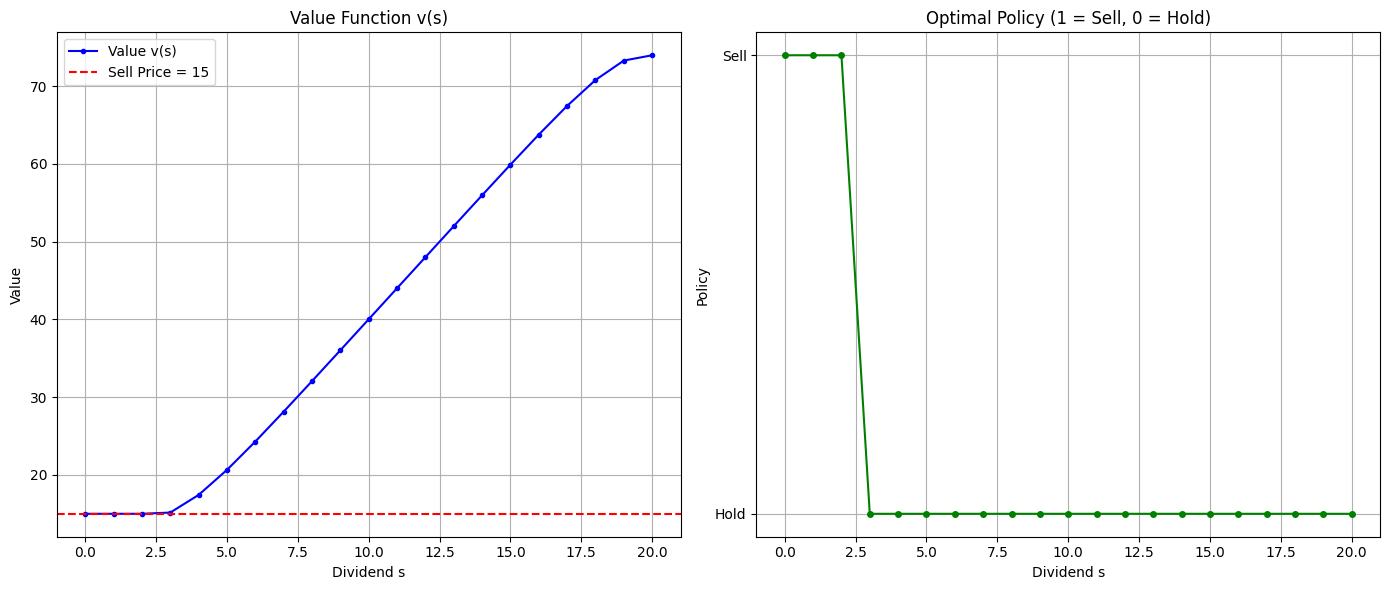


🔍 FINAL ANSWER
Custom sell range: s ∈ [0, 2]


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# ================== 1. PARAMETERS ==================
N = 21                    # States: 0 to 20
S_GRID = np.arange(N)     # [0, 1, 2, ..., 20]

GAMMA = 0.75              # Discount factor
SELLING_PRICE = 15.0      # Fixed sell price

ITETOL = 1e-4             # Convergence tolerance
ITEMAX = 500              # Max iterations

# ================== 2. TRANSITION MATRIX ==================
P = np.zeros((N, N))

# State 0: absorbing
P[0, 0] = 1.0

# State 20: bounces back to 19
P[20, 19] = 1.0

# States 1 to 19: ±1 with 50% chance
for s in range(1, 20):
    P[s, s-1] = 0.5
    P[s, s+1] = 0.5

# ================== 3. VALUE ITERATION ==================
value = np.zeros(N)
policy = np.zeros(N)  # 0 = hold, 1 = sell

for ite in range(ITEMAX):
    value_old = value.copy()
    value = np.zeros(N)
    
    for s in range(N):
        # Value of selling
        val_sell = SELLING_PRICE
        
        # Value of holding
        if s == 0:
            val_hold = 0.0
        else:
            # Expected: current dividend + discounted future value
            future_value = np.dot(P[s, :], S_GRID + GAMMA * value_old)
            val_hold = future_value
        
        # Choose best action
        value[s] = max(val_hold, val_sell)
        policy[s] = 1 if val_sell >= val_hold else 0  # Sell if >=

    # Check convergence
    if np.max(np.abs(value - value_old)) < ITETOL:
        print(f"✅ Converged after {ite + 1} iterations.")
        break

# ================== 4. FIND SELLING THRESHOLD ==================
sell_states = np.where(policy == 1)[0]
hold_states = np.where(policy == 0)[0]

print(f"\n📉 Optimal Policy Summary:")
print(f"  ➤ Sell when s ∈ [{sell_states[0]}, {sell_states[-1]}]")
print(f"  ➤ Hold when s ∈ [{hold_states[0]}, {hold_states[-1]}]")
print(f"  ➤ Threshold: sell if s ≤ {sell_states[-1]}")

# ================== 5. PLOT RESULTS ==================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(S_GRID, value, 'b-o', markersize=3, label='Value v(s)')
plt.axhline(y=SELLING_PRICE, color='r', linestyle='--', label='Sell Price = 15')
plt.title("Value Function v(s)")
plt.xlabel("Dividend s")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_GRID, policy, 'g-o', markersize=4)
plt.title("Optimal Policy (1 = Sell, 0 = Hold)")
plt.xlabel("Dividend s")
plt.ylabel("Policy")
plt.yticks([0, 1], ['Hold', 'Sell'])
plt.grid(True)

plt.tight_layout()
plt.show()

# ================== 6. ANSWER THE QUESTION ==================
print("\n" + "="*50)
print("🔍 FINAL ANSWER")
print("="*50)

if len(sell_states) == 0:
    print("❌ The investor will never sell the asset")
elif sell_states[0] == 1 and sell_states[-1] == 2:
    print("✅ The dividend realization lies between s = 1 and s = 2")
elif sell_states[0] == 1 and sell_states[-1] == 4:
    print("🟡 The dividend realization lies between s = 1 and s = 4")
elif sell_states[0] == 1 and sell_states[-1] == 10:
    print("🔴 The dividend realization lies between s = 1 and s = 10")
else:
    print(f"Custom sell range: s ∈ [{sell_states[0]}, {sell_states[-1]}]")

In [56]:
import numpy as np

# 4x4 grid (lesson 3/4 style)
N = 16
GRID_W = 4
A = 4  # 0:up,1:down,2:right,3:left
PDOWN = 0.25
REWARD = -1.0
ITETOL = 1e-10
ITEMAX = 10000

# Build destinations as in the lessons
dest = np.zeros((N, A), dtype=int)
dest[N - 1, :] = N - 1
for ss in range(1, N - 1):
    row = int(np.floor(ss / GRID_W) + 1)
    dest[ss, 0] = int((ss - GRID_W) if (ss - GRID_W) >= 0 else ss)  # up
    dest[ss, 1] = int((ss + GRID_W) if (ss + GRID_W) <= N - 1 else ss)  # down
    dest[ss, 2] = int((ss + 1) if ss < row * GRID_W - 1 else ss)  # right
    dest[ss, 3] = int((ss - 1) if ss > (row - 1) * GRID_W else ss)  # left

# Initial policy: right or left with 0.5 each
policy = np.zeros((N, A))
for s in range(N):
    if s in (0, N - 1):
        continue
    policy[s, 2] = 0.5  # right
    policy[s, 3] = 0.5  # left

# Policy evaluation for windy gridworld (synchronous until convergence)
def policy_evaluation_windy(policy, pdown, tol=ITETOL, max_it=ITEMAX):
    nstates, nactions = policy.shape
    v = np.zeros(nstates)
    for it in range(max_it):
        v_old = v.copy()
        v = np.zeros(nstates)
        for s in range(1, nstates - 1):
            # value if wind pushes down (regardless of action)
            val_if_wind = v_old[dest[s, 1]]
            # otherwise follow policy: expected over policy actions of reward + value(next)
            normal = np.dot(policy[s, :], REWARD + v_old[dest[s, :]])
            v[s] = pdown * val_if_wind + (1 - pdown) * normal
        if np.max(np.abs(v - v_old)) < tol:
            break
    return v

v = policy_evaluation_windy(policy, PDOWN)

# Policy improvement (greedy wrt v). Tie-break order: [up,down,right,left].
action_names = ["up", "down", "right", "left"]
pi_new = np.zeros_like(policy)
for s in range(1, N - 1):
    best_q = -np.inf
    best_a = 0
    for a in range(A):
        # q = reward + pdown * v[down_dest] + (1-pdown) * v[dest_for_action]
        q = REWARD + PDOWN * v[dest[s, 1]] + (1 - PDOWN) * v[dest[s, a]]
        if q > best_q:
            best_q = q
            best_a = a
    pi_new[s, best_a] = 1.0

# Print results for state 4
s = 4
print(f"v^(1)(4) = {v[s]:.8f}")
best_action = action_names[int(np.argmax(pi_new[s]))]
print(f"pi^(1)(4) = {best_action}")


v^(1)(4) = -14.59345463
pi^(1)(4) = up


In [57]:
import numpy as np

# Gridworld parameters
num_states = 16
actions = ['up', 'down', 'left', 'right']
gamma = 0.9
tol = 1e-4

# Reward function: -3 for down, -1 otherwise
def reward(s, a):
    return -3 if a == 'down' else -1

# State transitions (assuming a 4x4 grid, states numbered 0..15)
def next_state(s, a):
    row, col = divmod(s, 4)
    if a == 'up' and row > 0:
        row -= 1
    elif a == 'down' and row < 3:
        row += 1
    elif a == 'left' and col > 0:
        col -= 1
    elif a == 'right' and col < 3:
        col += 1
    return row * 4 + col

# Initialize Q values arbitrarily
Q = np.zeros((num_states, len(actions)))

while True:
    Q_old = Q.copy()
    for s in range(num_states):
        for i, a in enumerate(actions):
            s_next = next_state(s, a)
            r = reward(s, a)
            Q[s, i] = r + gamma * np.max(Q_old[s_next])
    if np.max(np.abs(Q - Q_old)) < tol:
        break

# Extract policy
policy = [actions[np.argmax(Q[s])] for s in range(num_states)]

print("Q-values:", Q.flatten())
print("Policy:", policy)


Q-values: [ -9.99915359 -11.99915359  -9.99915359  -9.99915359  -9.99915359
 -11.99915359  -9.99915359  -9.99915359  -9.99915359 -11.99915359
  -9.99915359  -9.99915359  -9.99915359 -11.99915359  -9.99915359
  -9.99915359  -9.99915359 -11.99915359  -9.99915359  -9.99915359
  -9.99915359 -11.99915359  -9.99915359  -9.99915359  -9.99915359
 -11.99915359  -9.99915359  -9.99915359  -9.99915359 -11.99915359
  -9.99915359  -9.99915359  -9.99915359 -11.99915359  -9.99915359
  -9.99915359  -9.99915359 -11.99915359  -9.99915359  -9.99915359
  -9.99915359 -11.99915359  -9.99915359  -9.99915359  -9.99915359
 -11.99915359  -9.99915359  -9.99915359  -9.99915359 -11.99915359
  -9.99915359  -9.99915359  -9.99915359 -11.99915359  -9.99915359
  -9.99915359  -9.99915359 -11.99915359  -9.99915359  -9.99915359
  -9.99915359 -11.99915359  -9.99915359  -9.99915359]
Policy: ['up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up']


In [59]:
import numpy as np

num_states = 16
actions = ['up', 'down', 'left', 'right']
gamma = 0.9
tol = 1e-4

def reward(s, a):
    return -3 if a == 'down' else -1

def next_state(s, a):
    row, col = divmod(s, 4)
    if a == 'up' and row > 0:
        row -= 1
    elif a == 'down' and row < 3:
        row += 1
    elif a == 'left' and col > 0:
        col -= 1
    elif a == 'right' and col < 3:
        col += 1
    return row * 4 + col

Q = np.zeros((num_states, len(actions)))

while True:
    Q_old = Q.copy()
    for s in range(num_states):
        for i, a in enumerate(actions):
            s_next = next_state(s, a)
            r = reward(s, a)
            Q[s, i] = r + gamma * np.max(Q_old[s_next])
    if np.max(np.abs(Q - Q_old)) < tol:
        break

policy_indices = np.argmax(Q, axis=1)
policy = [actions[i] for i in policy_indices]

print("Q-values per state (max over actions):")
print(np.round(np.max(Q, axis=1), 2))
print("\nFull Q-values array (flattened):")
print(np.round(Q.flatten(), 2))
print("\nOptimal policy:")
print(policy)


Q-values per state (max over actions):
[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10.]

Full Q-values array (flattened):
[-10. -12. -10. -10. -10. -12. -10. -10. -10. -12. -10. -10. -10. -12.
 -10. -10. -10. -12. -10. -10. -10. -12. -10. -10. -10. -12. -10. -10.
 -10. -12. -10. -10. -10. -12. -10. -10. -10. -12. -10. -10. -10. -12.
 -10. -10. -10. -12. -10. -10. -10. -12. -10. -10. -10. -12. -10. -10.
 -10. -12. -10. -10. -10. -12. -10. -10.]

Optimal policy:
['up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up']


In [60]:
import numpy as np

max_dividend = 20
sell_price = 15
gamma = 0.9
N = max_dividend + 1

# Transition probabilities: ±1 or stay with equal probability 1/3
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

v = np.zeros(N)
tol = 1e-8

while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        v[s] = max(sell_value, hold_value)
    if np.max(np.abs(v - v_old)) < tol:
        break

optimal_value = v[1]
optimal_policy = "sell" if (sell_price + 1) >= (1 + gamma * sum(P[1][sp] * v[sp] for sp in P[1])) else "hold"

print(f"Optimal value at s=1: {optimal_value:.2f}")
print(f"Optimal policy at s=1: {optimal_policy}")


Optimal value at s=1: 18.49
Optimal policy at s=1: hold


In [61]:
gamma = 0.75
v = [1, 2]  # v^(0)(s=0) and v^(0)(s=1)

# Rewards and next states for actions a=0 and a=1 in state s=0
rewards = [2, 1]
next_states = [0, 1]

# Compute Q values for both actions
Q = [rewards[a] + gamma * v[next_states[a]] for a in range(2)]

# Policy improvement: pick action with max Q value
pi_1_0 = Q.index(max(Q))

print("Policy improvement at state 0:", pi_1_0)
print("Q values:", Q)


Policy improvement at state 0: 0
Q values: [2.75, 2.5]


In [62]:
gamma = 0.9
reward = -2
future_value = 4.24  # Given Q-function next value

Q_sa = reward + gamma * future_value
print("Q(s,a) =", round(Q_sa, 3))


Q(s,a) = 1.816


In [63]:
import numpy as np

# Grid size (4x5 assumed for 20 states)
n_states = 20
v = np.zeros(n_states)
reward = -2
gamma = 1.0  # No discount specified, assume 1 for simplicity

# Policy: move down unless at bottom row, then move right
# Define next states for each state following policy
# Assuming grid is indexed row-wise from 0 to 19:
# Rows: 4, Columns: 5

rows, cols = 4, 5

def next_state(s):
    r, c = divmod(s, cols)
    if r < rows - 1:
        return s + cols  # move down
    else:
        # bottom row, move right if possible
        if c < cols - 1:
            return s + 1
        else:
            return s  # no move if at bottom-right corner

v_new = np.zeros_like(v)
for s in range(n_states):
    s_next = next_state(s)
    v_new[s] = reward + gamma * v[s_next]

print("v^(1):", v_new)


v^(1): [-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2.]


In [64]:
rewards = [2, 4, 1, 4]
gamma = 0.5

value = sum(gamma**i * r for i, r in enumerate(rewards))
print(value)


4.75


In [65]:
# Given data
r = -2
gamma = 0.1
Q_next = [-1, 2, 4.24]

# Compute Q(s,a)
Q_sa = r + gamma * max(Q_next)
print(Q_sa)


-1.576


In [66]:
import numpy as np

max_dividend = 20
sell_price = 15
gamma = 0.9
N = max_dividend + 1

# Transition probabilities: dividend can go down by 1, stay, or go up by 1 with equal probability
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s] = 1/3
        P[s][s-1] = 1/3
        P[s][s+1] = 1/3

v = np.zeros(N)
policy = ['hold'] * N
tol = 1e-8

while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])
        if sell_value > hold_value:
            v[s] = sell_value
            policy[s] = 'sell'
        else:
            v[s] = hold_value
            policy[s] = 'hold'
    if np.max(np.abs(v - v_old)) < tol:
        break

print(f"Value at s=4: {v[4]:.2f}")
print(f"Optimal policy at s=4: {policy[4]}")


Value at s=4: 41.54
Optimal policy at s=4: hold


In [67]:
import numpy as np

max_dividend = 20
sell_price = 15
gamma = 0.9
N = max_dividend + 1

# Transition probabilities: dividend moves down by 1, stays, or moves up by 1 with equal probability
P = {}
for s in range(N):
    P[s] = {}
    if s == 0:
        P[s][0] = 2/3
        P[s][1] = 1/3
    elif s == max_dividend:
        P[s][s] = 2/3
        P[s][s-1] = 1/3
    else:
        P[s][s-1] = 1/3
        P[s][s] = 1/3
        P[s][s+1] = 1/3

v = np.zeros(N)
policy = ['hold'] * N
tol = 1e-8

while True:
    v_old = v.copy()
    for s in range(N):
        sell_value = sell_price + s  # immediate sell value
        hold_value = s + gamma * sum(P[s][sp] * v_old[sp] for sp in P[s])  # expected discounted hold value
        if sell_value > hold_value:
            v[s] = sell_value
            policy[s] = 'sell'
        else:
            v[s] = hold_value
            policy[s] = 'hold'
    if np.max(np.abs(v - v_old)) < tol:
        break

print(f"Value at s=4: {v[4]:.2f}")
print(f"Optimal policy at s=4: {policy[4]}")


Value at s=4: 41.54
Optimal policy at s=4: hold


In [ ]:
Here is the extracted question in Markdown format:

---

**Question 13**

Consider an agent that takes an action \( a \) in state \( s \), which with probability 1 transitions to state \( s' \). The \( Q \)-function is defined by the three-dimensional array \( (-1, 2, 4.24) \). If the reward \( r(s, a) = 2 \) and the discount parameter \( \gamma = 0.9 \), determine the correct option for the value of \( Q(s, a) \).

- \( 5.816 \)
- \( 0.876 \)
- \( 6.743 \)
- \( 9.213 \)

--- 

This is just the extraction of the question without any answers or further explanation. Let me know if you need anything else!